# <p style='font-family: Signika+Negative; background-color:#E1F5FE; font-weight:bold; color:#0288D1; border:4px solid #0288D1; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>🔎 **Multilingual Sentiment Analysis** 🚀</p>


In [1]:
import torch 
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding

# HUGGING FACE MODELS FOR TESTING MY MODEL
from datasets import load_dataset

2025-12-05 17:27:26.120508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764955646.491054      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764955646.605992      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# LOAD DATA

sentiment_df = pd.read_csv(r'/kaggle/input/sentiment-analysis-dataset/sentiment_data.csv')

# GET THE FIRST 50000 DATA EACH SENTIMENT
sentiment_df = sentiment_df.groupby('Sentiment', group_keys=False).apply(lambda x: x.head(50000))

sentiment_df

/tmp/ipykernel_38/2465736621.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sentiment_df = sentiment_df.groupby('Sentiment', group_keys=False).apply(lambda x: x.head(50000))


,Unnamed: 0,Comment,Sentiment
1,1,nz retailers don’t even contactless credit car...,0
3,3,whenever go place doesn’t take apple pay doesn...,0
14,14,holy crap looking chroma systems back designin...,0
53,53,every person wired brings show act like theyve...,0
55,55,face describing hops killed “some smell pretty...,0
...,...,...,...
123049,123827,congratulations modi indian scientists made pr...,2
123050,123828,modi new shyamalan,2
123052,123830,nirav modis seized artwork auctioned akbaruddi...,2
123053,123831,modi assure international community capability...,2


we dropped any data with null values

In [3]:
# DROP NULL VALUES

display(sentiment_df.isna().sum())

sentiment_df.dropna(inplace = True)

print(f'Successful Drop NaN Values')

Unnamed: 0      0
Comment       185
Sentiment       0
dtype: int64

Successful Drop NaN Values


# <p style='font-family: Signika+Negative; background-color:#E1F5FE; font-weight:bold; color:#0288D1; border:4px solid #0288D1; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>📁 **Data Loader** 🎬</p>

In [4]:
# CREATE CUSTOM DATASET

class CustomDataset(Dataset):

  # CONSTRUCTOR
  def __init__(self, texts, labels, tokenizer, max_length = None):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]

    # TOKENIZATION
    text_encoded = self.tokenizer(text, truncation = True, add_special_tokens = True, return_tensors = 'pt')

    # RETURN DICT
    return {'input_ids' : text_encoded['input_ids'].squeeze(0),
            'attention_mask' : text_encoded['attention_mask'].squeeze(0),
            'labels' : torch.tensor(label, dtype = torch.long)}

In [5]:
# SPLIT DATASET

train_text, test_text, train_label, test_label = train_test_split(sentiment_df['Comment'], sentiment_df['Sentiment'], 
                                                                  test_size = 0.1, random_state = 2025, 
                                                                  stratify = sentiment_df['Sentiment'])

train_text, val_text, train_label, val_label = train_test_split(train_text, train_label, 
                                                                test_size = 0.09, random_state = 2025, 
                                                                stratify = train_label)

# RESET INDEX
train_text = train_text.reset_index(drop = True)
train_label = train_label.reset_index(drop = True)
val_text = val_text.reset_index(drop = True)
val_label = val_label.reset_index(drop = True)
test_text = test_text.reset_index(drop = True)
test_label = test_label.reset_index(drop = True)


train_text.shape, val_text.shape, test_text.shape, type(train_text), type(val_text), type(test_text)

((122698,),
 (12135,),
 (14982,),
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [6]:
# CONFIG DATASET

# DEFINE XLM-R BASE
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = 'xlm-roberta-base')
encoder = AutoModel.from_pretrained(pretrained_model_name_or_path = 'xlm-roberta-base')

# CUSTOM DATASET
train_dataset = CustomDataset(train_text, train_label, tokenizer, max_length = None)
val_dataset = CustomDataset(val_text, val_label, tokenizer, max_length = None)
test_dataset = CustomDataset(test_text, test_label, tokenizer, max_length = None)

# DATA COLLATOR
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = 'pt')

# DATA LOADER
train_loader = DataLoader(dataset = train_dataset, batch_size = 8, shuffle = True, collate_fn = data_collator)
val_loader = DataLoader(dataset = val_dataset, batch_size = 8, shuffle = False, collate_fn = data_collator)
test_loader = DataLoader(dataset = test_dataset, batch_size = 8, shuffle = False, collate_fn = data_collator)

len(train_loader), len(val_loader), len(test_loader), train_loader

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

(15338, 1517, 1873, <torch.utils.data.dataloader.DataLoader at 0x79627c8bc790>)

# <p style='font-family: Signika+Negative; background-color:#E1F5FE; font-weight:bold; color:#0288D1; border:4px solid #0288D1; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>🧠 **Build Model Architecture** 🤖</p>

<div style="
  background-color: #E3F2FD; 
  border-left: 6px solid #0277BD; 
  border-top: 6px solid #0277BD; 
  border-right: 6px solid #0277BD; 
  border-bottom: 6px solid #0277BD; 
  border-radius: 12px; 
  padding: 16px 22px; 
  font-size: 16px; 
  font-family: 'Signika Negative', sans-serif; 
  color: #01579B; 
  box-shadow: 0 4px 10px rgba(0, 0, 0, 0.15); 
  transition: transform 0.3s ease, box-shadow 0.3s ease;">


  <p style="
    margin: 0; 
    font-family: Signika+Negative; background-color
    font-size: 15px; 
    line-height: 1.6; 
    color: #0D47A1;">
    For model architecture, we use XLM-R as a Feature Extractor non-trainable and then we pass with Multi Layer Perceptron (MLP) as classification Head
  </p>
</div>

In [7]:
class ClassificationLayer(torch.nn.Module):
    def __init__(self, encoder, hidden_dim, num_labels):
        super(ClassificationLayer, self).__init__()
        self.encoder = encoder
        
        # FREEZE LAYER
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.dropout = torch.nn.Dropout(0.2)
        self.fc1 = torch.nn.Linear(in_features = encoder.config.hidden_size, out_features = hidden_dim)
        self.fc2 = torch.nn.Linear(in_features = hidden_dim, out_features = 2048)
        self.fc3 = torch.nn.Linear(in_features = 2048, out_features = 512)
        self.fc4 = torch.nn.Linear(in_features = 512, out_features = 108)
        self.relu = torch.nn.ReLU()

        self.output = torch.nn.Linear(in_features = 108, out_features = num_labels)

        # STABILIZER
        #self.norm = torch.nn.LayerNorm(encoder.config.hidden_size)

    # FORWARD PROPAGATION
    def forward(self, input_idx, attention_mask):
        encoder_output = self.encoder(input_ids = input_idx, attention_mask = attention_mask) # --> BATCH SIZE, SEQ LENGTH, HIDDEN SIZE
        pooled = encoder_output.last_hidden_state[:, 0, :] # [B, H]
        
        dropout = self.dropout(pooled)
        
        # HIDDEN LAYER
        hidden_layer1 = self.relu(self.fc1(pooled))
        dropout1 = self.dropout(hidden_layer1)
        hidden_layer2 = self.relu(self.fc2(dropout1))
        dropout2 = self.dropout(hidden_layer2)
        hidden_layer3 = self.relu(self.fc3(dropout2))
        dropout3 = self.dropout(hidden_layer3)
        hidden_layer4 = self.relu(self.fc4(dropout3))
        dropout4 = self.dropout(hidden_layer4)
        
        output = self.output(dropout4)

        return output

<div style="
  background-color: #E3F2FD; 
  border-left: 6px solid #0277BD; 
  border-top: 6px solid #0277BD; 
  border-right: 6px solid #0277BD; 
  border-bottom: 6px solid #0277BD; 
  border-radius: 12px; 
  padding: 16px 22px; 
  font-size: 16px; 
  font-family: 'Signika Negative', sans-serif; 
  color: #01579B; 
  box-shadow: 0 4px 10px rgba(0, 0, 0, 0.15); 
  transition: transform 0.3s ease, box-shadow 0.3s ease;">


  <p style="
    margin: 0; 
    font-family: Signika+Negative; background-color
    font-size: 15px; 
    line-height: 1.6; 
    color: #0D47A1;">
    Since I had already trained the neural network model previously, I only needed to load the model.
  </p>
</div>

In [8]:
# LOAD PREVIOUS MODEL

model_checkpoint = torch.load("/kaggle/input/multilingual-sentiment-analysis/pytorch/multilingual-sentiment-analysis/3/last_checkpoint_0.81.pt", map_location = 'cpu')

# DISPLAY CHECKPOINT
#print(type(model_checkpoint))
print(model_checkpoint.keys())

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'val_accuracy', 'train_loss'])


In [9]:
# LOAD PARAMETERS OF PREVIOUS MODEL

# LOAD WEIGHT & BIAS PARAMETERS 
model = ClassificationLayer(encoder = encoder, hidden_dim = 5048, num_labels = 3)
model = torch.nn.DataParallel(model).to('cuda')
model.load_state_dict(model_checkpoint['model_state_dict'])  # --> LOAD WEIGHT

model

DataParallel(
  (module): ClassificationLayer(
    (encoder): XLMRobertaModel(
      (embeddings): XLMRobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): XLMRobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x XLMRobertaLayer(
            (attention): XLMRobertaAttention(
              (self): XLMRobertaSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): XLMRobertaSelfOutput(
            

# <p style='font-family: Signika+Negative; background-color:#E1F5FE; font-weight:bold; color:#0288D1; border:4px solid #0288D1; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>🧠 **Config & Train Model** 🤖</p>

In [10]:
# FUNCTION TO EVALUATE MODEL

# ------SAMPLING DATA TO EVALUATE------
def sampling(dataset, sampling_freq):
    """
    Sampling random subset dari dataset.
    sampling_freq = float (0-1), proporsi data yang dipakai.
    """
    total_len = len(dataset)
    sample_size = int(total_len * sampling_freq)

    sampled_indices = random.sample(range(total_len), sample_size)
    subset = torch.utils.data.Subset(dataset, sampled_indices)

    return subset

# ---------------MISSCLASIFICATION-----------------
def misclassification(model, data_loader, k = 10, all_predictions = None, all_labels = None, all_texts = None):

    #acc, all_pred, all_label, all_text = evaluate(model, data_loader, sampling_freq = 0.05)

    y_preds = torch.cat(all_predictions).cpu().numpy()
    y_true = torch.cat(all_labels).cpu().numpy()

    i = 0

    # CHECK MISSCLASSIFICATION
    missclassif = []
    for text, true, pred in zip(all_texts, y_true, y_preds):

        if i == k:
            break

        # IF THERE'S MISCLASSIF 
        if true != pred:
            missclassif.append((text, true, pred))  
            i += 1

    return missclassif


# --------------EVALUATION----------------------
def evaluate(model, data_loader, sampling_freq = None, plot_cf = False, title = None, show_misclassification = False, device = 'cpu'):
    model.eval()

    # IF SAMPLING
    if sampling_freq is not None:
        subset = sampling(data_loader.dataset, sampling_freq)

        # TRANSFORM BACK INTO DATA LOADER AFTER SAMPLING
        data_loader = torch.utils.data.DataLoader(
            subset,
            batch_size=data_loader.batch_size,
            shuffle=False,
            collate_fn=data_loader.collate_fn
        )
        
    correct = 0
    total_sample = 0

    all_prediction = []
    all_labels = []
    all_texts = []

    with torch.no_grad():
        for batch in data_loader:
      
            # UNPACK BATCH DATA
            input_idx = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['labels'].to(device)
            
            # PREDICT DATA
            y_pred_proba = model(input_idx, attention_mask)
    
            y_prediction = y_pred_proba.argmax(1)

            # CALCULATE CORRECT SAMPLE
            correct += (y_prediction == label).sum().item()
            total_sample += label.size(0)

            all_prediction.append(y_prediction.cpu())
            all_labels.append(label.cpu())

            # DECODE KEMBALI KE TEKS ASLI UNTUK MENGAMBIL TEKS ASLI
            decoded = tokenizer.batch_decode(input_idx, skip_special_tokens=True)
            all_texts.extend(decoded)

        # GABUNG LIST OF TENSORS JADI SATU
        y_preds = torch.cat(all_prediction).numpy()
        y_true = torch.cat(all_labels).numpy()

    # PLOT CONFUSION MATRIX?
    if plot_cf:
        # CONFUSION MATRIX
        conf_matrix = confusion_matrix(y_true, y_preds)
        plt.figure(figsize = (5.5, 3.5))
        sns.heatmap(conf_matrix, annot = True, cmap = 'coolwarm', fmt = 'd')
      
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(title)
        plt.show()
        
    acc = correct / total_sample 

    result_dict = {'accuracy' : acc, 
                   'all_prediction' : all_prediction, 
                   'all_labels' : all_labels, 
                   'all_texts' : all_texts}
    
    # DISPLAY MISCLASSIFICATION?
    if show_misclassification:
        false_text = misclassification(model, data_loader, k = None, all_predictions = all_prediction, all_labels = all_labels, all_texts = all_texts)
        result_dict['false_classification'] = false_text

    
    return result_dict

In [11]:
# DEFINE LOSS AND OPTIMIZER

criterion = torch.nn.CrossEntropyLoss(label_smoothing = 0.1)
optimizer = torch.optim.AdamW(params = model.parameters(), lr = 7e-5)
optimizer.load_state_dict(model_checkpoint['optimizer_state_dict'])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 8, gamma = 0.9)  # --> LR DROPPED 60% EVERY 2 EPOCH

In [16]:
# CHANGE LR OPTIMIZER
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-5

START TRAINING!
Iteration 0 Complete
Iteration 2000 Complete
Iteration 4000 Complete


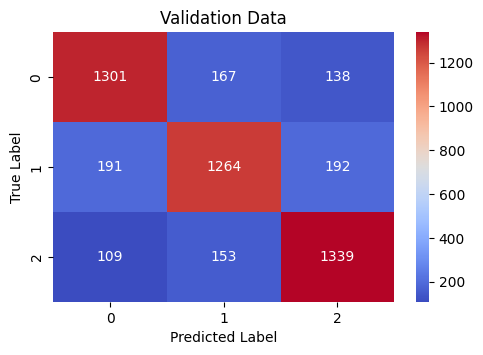

Epoch 1/25 : Train Loss = 0.6688, Train Accuracy = 0.8059, Val Accuracy = 0.8043
No improvement for 1 epoch(s).
Iteration 0 Complete
Iteration 2000 Complete
Iteration 4000 Complete


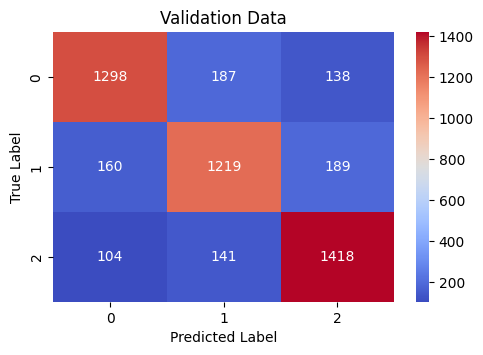

Epoch 2/25 : Train Loss = 0.6694, Train Accuracy = 0.8102, Val Accuracy = 0.8107
No improvement for 2 epoch(s).
Iteration 0 Complete
Iteration 2000 Complete
Iteration 4000 Complete


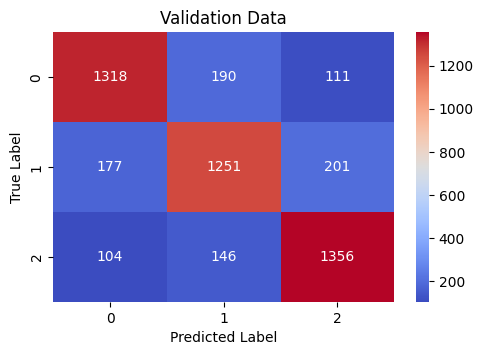

Epoch 3/25 : Train Loss = 0.6694, Train Accuracy = 0.8112, Val Accuracy = 0.8086
No improvement for 3 epoch(s).
Iteration 0 Complete
Iteration 2000 Complete
Iteration 4000 Complete


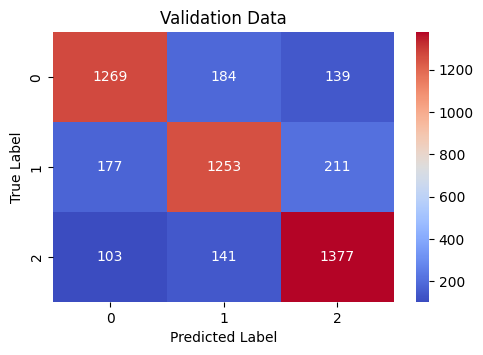

Epoch 4/25 : Train Loss = 0.6692, Train Accuracy = 0.8032, Val Accuracy = 0.8033
No improvement for 4 epoch(s).
LR Updated from 1e-05 ---> 9e-06
Iteration 0 Complete


KeyboardInterrupt: 

In [35]:
%%time
# TRAIN MODEL 

#print(f'CONTINUE TRAINING FROM EPOCH {model_checkpoint["epoch"]}!')
print(f'START TRAINING!')

EPOCHS = 25
patience = 6
best_val_acc = 0.8127
epochs_no_improve = 0

for epoch in range(0, EPOCHS):

    # SUBSAMPLING TRAIN DATA
    num_samples = int(len(train_dataset) * 0.7)
    indices = np.random.choice(len(train_dataset), num_samples, replace=False)
    sampler = SubsetRandomSampler(indices)

    subset_loader = DataLoader(
        dataset=train_dataset,
        batch_size = 16,
        sampler=sampler,
        collate_fn=data_collator
    )

    
    model.train()
    total_loss = 0

    for i, batch in enumerate(subset_loader):

        if i % 2000 == 0:
            print(f'Iteration {i} Complete')

        # UNPACK BATCH DATA
        input_idx = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        # PREDICT DATA
        prediction = model(input_idx, attention_mask)
        loss_function = criterion(prediction, labels)
        total_loss += loss_function.item()

        # BACKPROPAGATION
        loss_function.backward()
        optimizer.step()
        optimizer.zero_grad()

    # CALCULATE TRAIN LOSS
    avg_train_loss = total_loss / len(subset_loader)

    # VALIDATION
    train_accuracy, _, _, _ = evaluate(model, subset_loader, sampling_freq = 0.1, device = 'cuda')
    val_accuracy, _, _, _ = evaluate(model, val_loader, plot_cf = True, title = 'Validation Data', sampling_freq = 0.4, device = 'cuda')

    print(f'Epoch {epoch+1}/{EPOCHS} : '
          f'Train Loss = {avg_train_loss:.4f}, '
          f'Train Accuracy = {train_accuracy:.4f}, '
          f'Val Accuracy = {val_accuracy:.4f}')

    # EARLY STOPPING LOGIC
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        epochs_no_improve = 0

        checkpoint = {
            'epoch': epoch + 1,  # simpan epoch berikutnya
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
            'train_loss': avg_train_loss
        }
        torch.save(checkpoint, "best_model.pt")
        print("Validation accuracy improved! Model checkpoint saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break


    # LR SCHEDULER
    prev_lr = optimizer.param_groups[0]['lr']  # GET LR BEFORE UPDATED
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr'] # GET LR AFTER UPDATED

    # IF LR UPDATED
    if current_lr != prev_lr:
        print(f'LR Updated from {prev_lr} ---> {current_lr}')
    


# <p style='font-family: Signika+Negative; background-color:#E1F5FE; font-weight:bold; color:#0288D1; border:4px solid #0288D1; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>📚 **Quantization** ⏱️</p>

In [12]:
# DYNAMIC QUANTIZATION

quantized_model = model.module.to('cpu')  # --> REMOVE DATA PARALLEL

linear_layers = torch.nn.Sequential(quantized_model.fc1,
                                    quantized_model.fc2, 
                                    quantized_model.fc3,
                                    quantized_model.fc4,
                                    quantized_model.output)
# DEFINE DYNAMIC QUANTIZATION
layers_to_quantized = torch.quantization.quantize_dynamic(linear_layers,
                                                           {torch.nn.Linear},
                                                           dtype = torch.qint8)

# APLY DYNAMIC QUANTIZATION
(quantized_model.fc1, quantized_model.fc2, quantized_model.fc3, quantized_model.fc4, quantized_model.output) = layers_to_quantized

# MOVE TO CPU (BECAUSE DYNAMIC QUANTIZATION ONLY CAN BE DONE ON CPU)
quantized_model.to("cpu")
quantized_model.eval()

ClassificationLayer(
  (encoder): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)


In [14]:
# SAVE QUANTIZED MODEL
torch.save(quantized_model.state_dict(), "quantized_model.pth")

# <p style='font-family: Signika+Negative; background-color:#E1F5FE; font-weight:bold; color:#0288D1; border:4px solid #0288D1; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>📚 **Evaluation** ⏱️</p>

In [17]:
# LOAD HUGGING FACE DATASET (EVALUATION WITH EXTERNAL DATA)

def data_loading(dataset, tokenizer):

    # EXTRACT DATASET
    train_text, train_label = dataset['train']['text'], dataset['train']['label']
    val_text, val_label     = dataset['validation']['text'], dataset['validation']['label']
    test_text, test_label   = dataset['test']['text'], dataset['test']['label']

    # LABEL MAPPING
    label_map = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
    train_label = [label_map[label] for label in train_label]
    val_label   = [label_map[label] for label in val_label]
    test_label  = [label_map[label] for label in test_label]
    
    # CUSTOM DATASET
    train_custom = CustomDataset(train_text, train_label, tokenizer)
    val_custom   = CustomDataset(val_text, val_label, tokenizer)
    test_custom  = CustomDataset(test_text, test_label, tokenizer)

    # DATA LOADER 
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")  # --> DYNAMIC PADDING
    train_loader = DataLoader(train_custom, batch_size=8, shuffle=True, collate_fn=data_collator)
    val_loader   = DataLoader(val_custom, batch_size=8, shuffle=False, collate_fn=data_collator)
    test_loader  = DataLoader(test_custom, batch_size=8, shuffle=False, collate_fn=data_collator)

    return train_loader, val_loader, test_loader

# LOAD DATASET FROM HUGGING FACE (INFERENCE)
from datasets import load_dataset
dataset = load_dataset("clapAI/MultiLingualSentiment")

# APPLY DATA LOADER
train_loader_h, val_loader_h, test_loader_h = data_loading(dataset, tokenizer)


len(train_loader_h), len(val_loader_h), len(test_loader_h)

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/99.1M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/98.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3147478 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/393435 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/393436 [00:00<?, ? examples/s]

(393435, 49180, 49180)

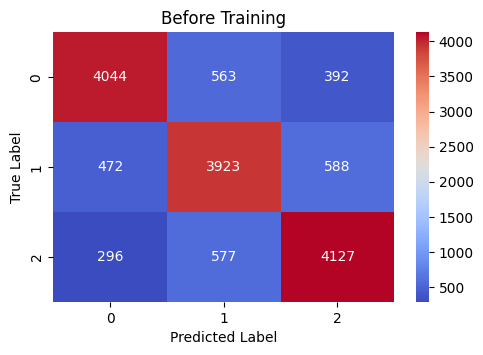

Accuracy : 0.8072353490855694
CPU times: user 7min 18s, sys: 5.4 s, total: 7min 24s
Wall time: 4min 3s


In [13]:
%%time
# TEST MODEL

result = evaluate(model, test_loader, plot_cf = True, title = 'Before Training', sampling_freq = 1, show_misclassification = True)

print(f'Accuracy : {result["accuracy"]}')

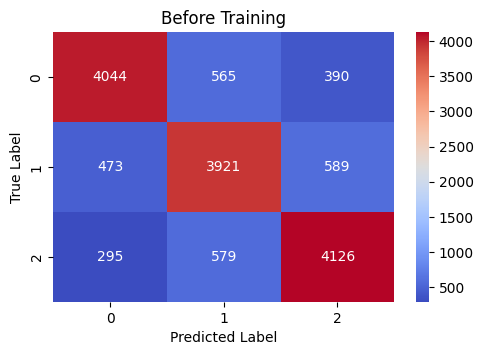

Accuracy : 0.8070351087972233
CPU times: user 21min 2s, sys: 9.01 s, total: 21min 11s
Wall time: 10min 36s


In [13]:
%%time
# CHECK MODEL PERFORMANCE ON QUANTIZED MODEL

result = evaluate(quantized_model, test_loader, plot_cf = True, title = 'Before Training', sampling_freq = 1, show_misclassification = True, device = 'cpu')

print(f'Accuracy : {result["accuracy"]}')

In [35]:
# DISPLAY MISSCLASSIFICATION

for sample in false_predict[:10]:
    print('True :', sample[1], 'Predicted :', sample[2],'.', sample[0])

True : 2 Predicted : 1 . guys serious question song like cds honest know wont reply maria
True : 2 Predicted : 0 . modi unstable frustrated choose one wisdom cunning intelligent shrewd empathysympathy acting
True : 0 Predicted : 2 . awh thats good get better soon
True : 2 Predicted : 0 . going school im actually tired today tho
True : 0 Predicted : 1 . self obsessed talks modi
True : 0 Predicted : 1 . youre miami right dont see hand delivery near future unfortunately
True : 0 Predicted : 1 . grrfatboy slim edc lineup
True : 1 Predicted : 0 . phone dead charger miles away sr ill talk august
True : 0 Predicted : 1 . jawahar lal nehru champion even post ââ created jln usse pehle hindustan mein hote nhi wasnâ jln modi wouldnâ place forget things
True : 1 Predicted : 0 . political needed everything thing differentiates modi others takes decisions like one


# <p style='font-family: Signika+Negative; background-color:#E1F5FE; font-weight:bold; color:#0288D1; border:4px solid #0288D1; border-radius:12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.2); padding:10px; text-align:center; transition: all 0.3s ease;'>🗂️ **Inference** 📥</p>

<div style="
  background-color: #E3F2FD; 
  border-left: 6px solid #0277BD; 
  border-top: 6px solid #0277BD; 
  border-right: 6px solid #0277BD; 
  border-bottom: 6px solid #0277BD; 
  border-radius: 12px; 
  padding: 16px 22px; 
  font-size: 16px; 
  font-family: 'Signika Negative', sans-serif; 
  color: #01579B; 
  box-shadow: 0 4px 10px rgba(0, 0, 0, 0.15); 
  transition: transform 0.3s ease, box-shadow 0.3s ease;">


  <p style="
    margin: 0; 
    font-family: Signika+Negative; background-color
    font-size: 15px; 
    line-height: 1.6; 
    color: #0D47A1;">
    For Inference, we use and test with different language of sentiment to check model performance on real data
  </p>
</div>

In [15]:
# INFERENCE

def inference(text, model, tokenizer):

    # ENCODE TEXT
    token = tokenizer(text, padding = True, truncation = True, return_tensors = 'pt')
    token_ids = token['input_ids'].to('cuda')
    attention_mask = token['attention_mask'].to('cuda')

    # DO INFERENCE
    model.eval()
    with torch.no_grad():
        logits = model(token_ids, attention_mask)

        # GET PROBABILITY AND LABEL
        probs = torch.softmax(logits, dim = -1)
        label = torch.argmax(probs, dim = -1).item()

    # LABEL MAPPING
    f = lambda x: 'Negatif' if x == 0 else ('Neutral' if x == 1 else 'Positive')
    sentiment = f(label)

    return probs, sentiment 


# DISPLAY INFERENCE
def get_inference(text):
    proba, sentiment = inference(text, model, tokenizer)
    
    print(text)
    print('Sentiment : ', sentiment)
    print(f'Probability = [Negative :{proba[0, 0]:.5f}], [Neutral : {proba[0, 1]:.5f}], [Positive : {proba[0, 2]:.5f}]')

In [16]:
input_text = "Aku pergi ke kampus pagi ini untuk mengikuti kuliah."

get_inference(input_text)

Aku pergi ke kampus pagi ini untuk mengikuti kuliah.
Sentiment :  Neutral
Probability = [Negative :0.05998], [Neutral : 0.88286], [Positive : 0.05715]


In [17]:
input_text = 'Makanannya enak banget, tapi pelayanannya buruk sekali.'

get_inference(input_text)

Makanannya enak banget, tapi pelayanannya buruk sekali.
Sentiment :  Neutral
Probability = [Negative :0.24504], [Neutral : 0.57529], [Positive : 0.17967]


In [39]:
input_text = 'Wah, internet lemot lagi, benar-benar menyenangkan.'

get_inference(input_text)

Wah, internet lemot lagi, benar-benar menyenangkan.
Sentiment :  Neutral
Probability = [Negative :0.13444], [Neutral : 0.44621], [Positive : 0.41934]


In [77]:
input_text = 'Hari ini terasa sangat melelahkan karena sejak pagi aku harus menghadapi kemacetan, kemudian rapat panjang yang tidak ada hasilnya, dan akhirnya pulang dengan perasaan frustasi.'

get_inference(input_text)

Hari ini terasa sangat melelahkan karena sejak pagi aku harus menghadapi kemacetan, kemudian rapat panjang yang tidak ada hasilnya, dan akhirnya pulang dengan perasaan frustasi.
Sentiment :  Negatif
Probability = [Negative :0.87662], [Neutral : 0.07763], [Positive : 0.04575]


In [78]:
input_text = 'Hari ini aku berjalan cukup jauh, melewati taman yang indah tapi juga penuh sampah di beberapa sudut.'

get_inference(input_text)

Hari ini aku berjalan cukup jauh, melewati taman yang indah tapi juga penuh sampah di beberapa sudut.
Sentiment :  Neutral
Probability = [Negative :0.16112], [Neutral : 0.75527], [Positive : 0.08361]


In [79]:
input_text = 'Walaupun presentasiku tadi penuh gangguan teknis, dosen beberapa kali terlihat mengangguk seolah menghargai usahaku, tapi aku tidak bisa berhenti merasa kalau senyumnya itu lebih mirip senyum iba daripada apresiasi, sehingga aku pulang dengan perasaan campur aduk antara lega karena sudah selesai dan kecewa karena mungkin tidak memberikan kesan yang sebenarnya ingin aku capai.'

get_inference(input_text)

Walaupun presentasiku tadi penuh gangguan teknis, dosen beberapa kali terlihat mengangguk seolah menghargai usahaku, tapi aku tidak bisa berhenti merasa kalau senyumnya itu lebih mirip senyum iba daripada apresiasi, sehingga aku pulang dengan perasaan campur aduk antara lega karena sudah selesai dan kecewa karena mungkin tidak memberikan kesan yang sebenarnya ingin aku capai.
Sentiment :  Neutral
Probability = [Negative :0.18687], [Neutral : 0.45653], [Positive : 0.35660]


In [80]:
input_text = 'Ketika aku mendapat kabar bahwa proposal penelitianku diterima dengan revisi besar-besaran, aku tersenyum kecil karena merasa ini kesempatan besar untuk memperbaiki pekerjaanku, namun di sisi lain aku juga sadar bahwa revisi yang diminta bisa memakan waktu berbulan-bulan dan membuat jadwal kuliahku berantakan, jadi aku tidak tahu harus merasa senang atau malah terbebani.'

get_inference(input_text)

Ketika aku mendapat kabar bahwa proposal penelitianku diterima dengan revisi besar-besaran, aku tersenyum kecil karena merasa ini kesempatan besar untuk memperbaiki pekerjaanku, namun di sisi lain aku juga sadar bahwa revisi yang diminta bisa memakan waktu berbulan-bulan dan membuat jadwal kuliahku berantakan, jadi aku tidak tahu harus merasa senang atau malah terbebani.
Sentiment :  Negatif
Probability = [Negative :0.46082], [Neutral : 0.32444], [Positive : 0.21474]


In [81]:
input_text = 'Aunque el concierto empezó con un retraso de casi una hora y el sonido no era tan claro como esperaba, terminé aplaudiendo con entusiasmo porque la energía de la multitud me contagió, aunque en el fondo sigo dudando si realmente disfruté de la música o simplemente del ambiente.'

get_inference(input_text)

Aunque el concierto empezó con un retraso de casi una hora y el sonido no era tan claro como esperaba, terminé aplaudiendo con entusiasmo porque la energía de la multitud me contagió, aunque en el fondo sigo dudando si realmente disfruté de la música o simplemente del ambiente.
Sentiment :  Neutral
Probability = [Negative :0.05601], [Neutral : 0.50413], [Positive : 0.43986]


In [82]:
input_text = 'Als ich endlich die Zusage für das Praktikum erhielt, war ich gleichzeitig erleichtert, weil sich monatelanges Warten gelohnt hatte, aber auch verunsichert, da die Stelle weit entfernt ist und ich nicht sicher bin, ob die Erfahrung wirklich meinen Erwartungen entsprechen wird.'

get_inference(input_text)

Als ich endlich die Zusage für das Praktikum erhielt, war ich gleichzeitig erleichtert, weil sich monatelanges Warten gelohnt hatte, aber auch verunsichert, da die Stelle weit entfernt ist und ich nicht sicher bin, ob die Erfahrung wirklich meinen Erwartungen entsprechen wird.
Sentiment :  Neutral
Probability = [Negative :0.11730], [Neutral : 0.59515], [Positive : 0.28755]


In [83]:
input_text = '長い間楽しみにしていた旅行がようやく実現したが、天気が予想以上に悪く、観光地のほとんどが閉まっていた。それでも静かな町並みを歩きながら、不思議と心が落ち着いた気がしたが、本当に満足したのか自分でもよく分からない。'

get_inference(input_text)

長い間楽しみにしていた旅行がようやく実現したが、天気が予想以上に悪く、観光地のほとんどが閉まっていた。それでも静かな町並みを歩きながら、不思議と心が落ち着いた気がしたが、本当に満足したのか自分でもよく分からない。
Sentiment :  Neutral
Probability = [Negative :0.16648], [Neutral : 0.48897], [Positive : 0.34455]


In [84]:
input_text = 'Когда я получил награду за проект, я улыбался и благодарил жюри, но внутри ощущал, что эта победа пришла слишком легко и, возможно, она недооценивает мои настоящие усилия, поэтому я не уверен, радуюсь ли я действительно или просто играю роль.'

get_inference(input_text)

Когда я получил награду за проект, я улыбался и благодарил жюри, но внутри ощущал, что эта победа пришла слишком легко и, возможно, она недооценивает мои настоящие усилия, поэтому я не уверен, радуюсь ли я действительно или просто играю роль.
Sentiment :  Neutral
Probability = [Negative :0.13201], [Neutral : 0.57953], [Positive : 0.28847]


In [40]:
input_text = "على الرغم من أنني شعرت بالفخر عندما أثنى المدير على تقريري، إلا أنني لم أستطع تجاهل الطريقة التي نظر بها زملائي إليّ، مزيج من الغيرة وربما عدم التصديق، مما جعلني غير متأكد ما إذا كان هذا النجاح يستحق كل هذا الثمن الاجتماعي."

get_inference(input_text)

على الرغم من أنني شعرت بالفخر عندما أثنى المدير على تقريري، إلا أنني لم أستطع تجاهل الطريقة التي نظر بها زملائي إليّ، مزيج من الغيرة وربما عدم التصديق، مما جعلني غير متأكد ما إذا كان هذا النجاح يستحق كل هذا الثمن الاجتماعي.
Sentiment :  Neutral
Probability = [Negative :0.21897], [Neutral : 0.61048], [Positive : 0.17054]
